In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

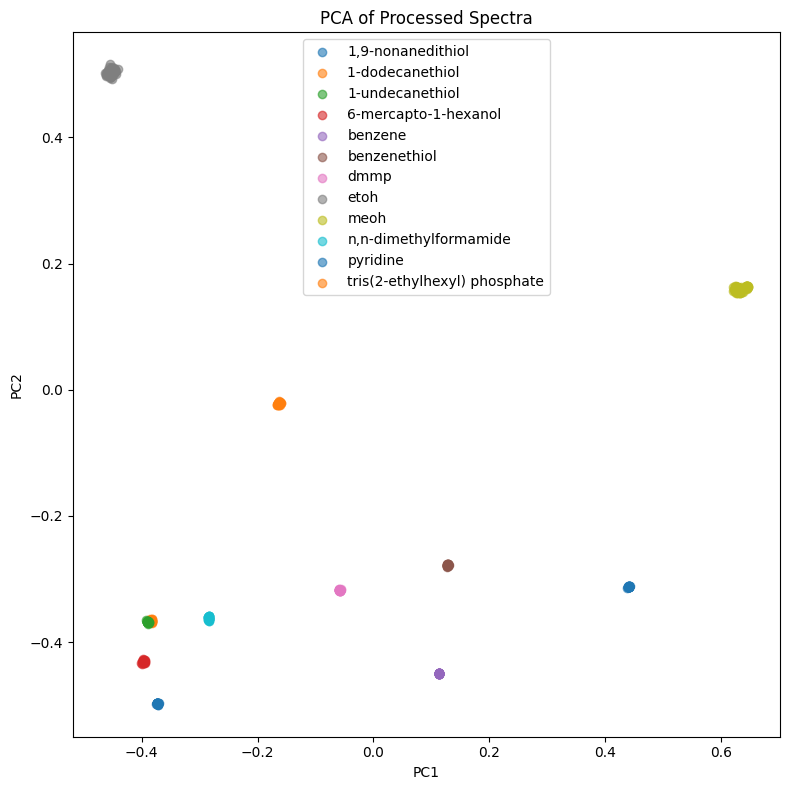

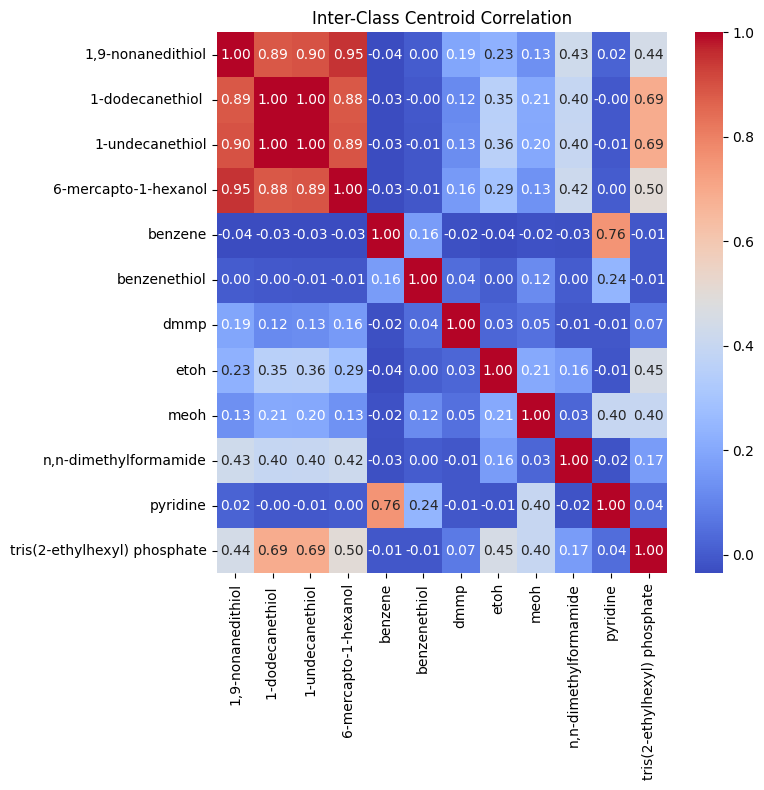

In [3]:
def baseline_AsLS(y,lam=1e4,p=0.01,niter =10):
    L =len(y)
    D = np.diff(np.eye(L),2)
    D = lam * D.dot(D.T)
    w = np.ones(L)
    for _ in range(niter):
        b = np.linalg.solve(np.diag(w) + D, w * y)
        w = p * (y > b) + (1 - p) * (y < b)
    return b

def preprocess(arr):
    out = np.zeros_like(arr)
    for i, spec in enumerate(arr):
        bkg = baseline_AsLS(spec)
        corr = spec - bkg
        nrm = np.linalg.norm(corr)
        out[i] = corr / nrm if nrm else corr
    return out

df = pd.read_csv('Jesse_Dataset/reference.csv')

wavs_str = df.columns[:-1]
wavs = wavs_str.astype(float)
wcols = wavs_str

spectra = df[wcols].values.astype(float)
species = df['Label'].values
proc = preprocess(spectra)

pca = PCA(n_components=2)
Z = pca.fit_transform(proc)

plt.figure(figsize=(8, 8))
for sp in np.unique(species):
    mask_sp = species == sp
    plt.scatter(Z[mask_sp,0], Z[mask_sp,1], label=sp, alpha=0.6)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of Processed Spectra')
plt.legend()
plt.tight_layout()
plt.show()

# Compute class centroids
centroids = {}
for sp in np.unique(species):
    centroids[sp] = proc[species == sp].mean(axis=0)

# Build correlation matrix
corr_matrix = pd.DataFrame(index=centroids.keys(), columns=centroids.keys(), dtype=float)
for sp1 in centroids:
    for sp2 in centroids:
        corr = np.corrcoef(centroids[sp1], centroids[sp2])[0,1]
        corr_matrix.loc[sp1, sp2] = corr

# Display correlation heatmap
plt.figure(figsize=(8,8))
sns.heatmap(corr_matrix.astype(float), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Inter-Class Centroid Correlation')
plt.tight_layout()
plt.show()
